In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_train = pd.read_csv("Q1_Train_Data.csv")
df_val = pd.read_csv("Q1_Validation_Data.csv")
df_test = pd.read_csv("Q1_Test_Data.csv")

In [3]:
trainImages = df_train['pixels'].str.split(' ', expand=True)
valImages = df_val['pixels'].str.split(' ', expand=True)
testImages = df_test['pixels'].str.split(' ', expand=True)

train_labels = df_train['emotion']
val_labels = df_val['emotion']
test_labels = df_test['emotion']

In [4]:
train_images_numeric = trainImages.apply(pd.to_numeric) 
val_images_numeric = valImages.apply(pd.to_numeric)
test_images_numeric = testImages.apply(pd.to_numeric)

In [16]:
print(train_images_numeric)

       0     1     2     3     4     5     6     7     8     9     ...  2294  \
0        70    80    82    72    58    58    60    63    54    58  ...   159   
1       151   150   147   155   148   133   111   140   170   174  ...   105   
2       231   212   156   164   174   138   161   173   182   200  ...   104   
3        24    32    36    30    32    23    19    20    30    41  ...   174   
4         4     0     0     0     0     0     0     0     0     0  ...    12   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
28704    84    85    85    85    85    85    85    85    86    86  ...    35   
28705   114   112   113   113   111   111   112   113   115   113  ...    83   
28706    74    81    87    89    95   100    98    93   105   120  ...   211   
28707   222   227   203    90    86    90    84    77    94    87  ...   136   
28708   195   199   205   206   205   203   206   209   208   210  ...   112   

       2295  2296  2297  2298  2299  23

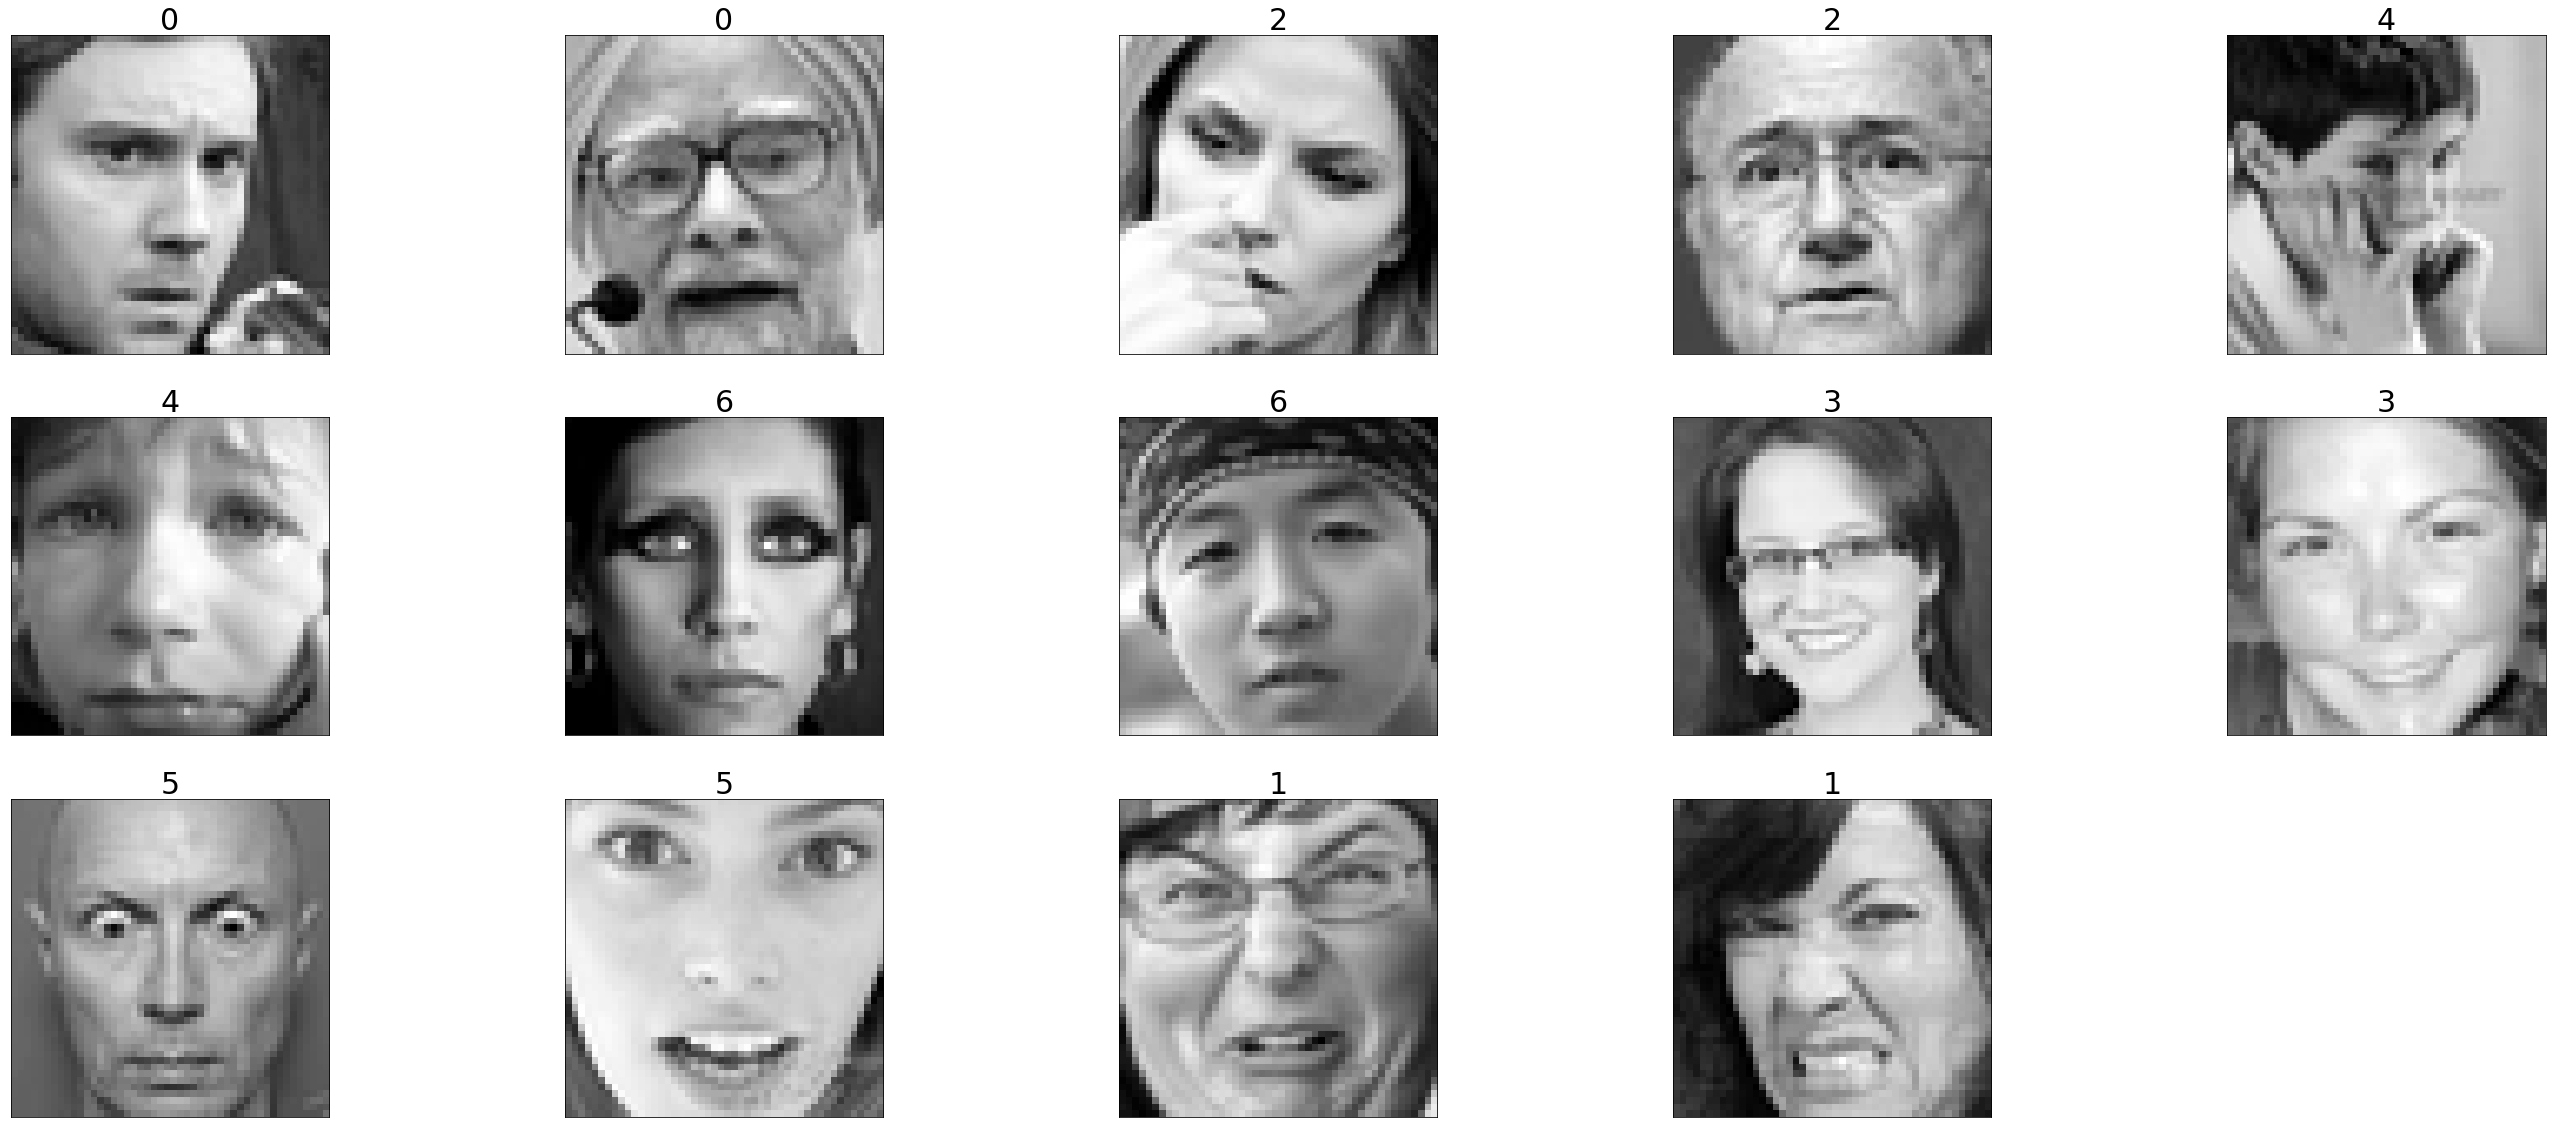

In [15]:
emotion_samples = {}
fig = plt.figure(figsize=(48,48))
p_id = 0

for emotion in train_labels.unique():
    img_id = train_labels.loc[train_labels == emotion].index
    emotion_samples[emotion] = img_id[:2]
    
    for idx in img_id[:2]:
        ax = fig.add_subplot(7, 5, p_id+1, xticks=[], yticks=[])
        ax.imshow(train_images_numeric.iloc[idx,:].values.reshape(48, 48), cmap='gray')
        ax.set_title(str(emotion),fontsize=30)
        p_id += 1

In [16]:
print(train_labels.value_counts())


3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: emotion, dtype: int64


In [6]:
from keras.regularizers import l2
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import PReLU
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV


from keras.utils import to_categorical
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from keras.layers import Conv2D, Flatten, MaxPooling2D
from keras import backend as K 
from hyperopt import space_eval

import time
import random


Using TensorFlow backend.


In [7]:
# preProcess
train_images_normalize = (train_images_numeric / 255) - 0.5
val_images_normalize = (val_images_numeric / 255) - 0.5
test_images_normalize = (test_images_numeric / 255) - 0.5

x_train_fnn = train_images_normalize.copy()
x_val_fnn = val_images_normalize.copy()
x_test_fnn = test_images_normalize.copy()

y_train = to_categorical(train_labels)
y_val = to_categorical(val_labels)
y_test = to_categorical(test_labels)

size_input = trainImages.shape[1]
size_class = train_labels.unique().shape[0]


In [9]:
K.clear_session()

In [43]:
def optimize_fnn(hyperparameter):
    K.clear_session()  
    fnn_model = Sequential()

    first_layer = True
    for layer_size in hyperparameter['network_config']:
        print("XXX",layer_size)
    
        if first_layer:
            fnn_model.add(Dense(layer_size, input_dim = size_input, activation=hyperparameter['activation_function'],kernel_regularizer = l2(hyperparameter['l2_penalty']),))
            first_layer = False
        else:
            fnn_model.add(Dense(layer_size, activation=hyperparameter['activation_function'],kernel_regularizer = l2(hyperparameter['l2_penalty'])))

    fnn_model.add(Dropout(hyperparameter['dropout_prob']))

    fnn_model.add(Dense(size_class, activation='softmax'))

    fnn_model.compile(optimizer=hyperparameter['optimizer'], loss='categorical_crossentropy', metrics=['accuracy'],)

    train_X, train_y = trainImages, y_train
    valid_X, valid_y = valImages, y_val

    start = time.time()
    fnn_history = fnn_model.fit(x_train_fnn, y_train, epochs=20, batch_size=256, verbose=0)
    end = time.time()

#   print(fnn_model.summary())

    performance_fnn = fnn_model.evaluate(x_val_fnn, y_val, verbose=0)

    print("----------------------------------------------------")

    print("Hyperparameters: ", (hyperparameter))
    print()
    print("No. of parameters : %d" % (fnn_model.count_params()))
    print("Training time : %.2f s" % (end-start))
    print("Training Accuracy : %.3f" % (fnn_history.history['accuracy'][-1]))
    print("Validation Accuracy : %.3f" % (performance_fnn[1]))
    print("----------------------------------------------------")
    
    if random.random() < 0.35:
        plt.plot(fnn_history.history['loss'])
        plt.title('Cross-entropy loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.show()
    print("----------------------------------------------------")

# We want to minimize loss i.e. negative of accuracy
    return({"status": STATUS_OK, "loss": -1*performance_fnn[1], "model":fnn_model})

In [45]:
# Define search space for hyper-parameters
space_fnn = {
    # The kernel_size for convolutions:
    'network_config': hp.choice('network_config', [[4,2,1],[5,3,2]]),
    # The stride_size for convolutions:
    'activation_function': hp.choice('activation_function', ['tanh', 'relu']),
    # Uniform distribution in finding appropriate dropout values
    'dropout_prob': hp.uniform('dropout_prob', 0.1, 0.35),
    # regularization:
    'l2_penalty': hp.choice('l2_penalty', [0.001,0.003]),
    # Choice of optimizer 
    'optimizer': hp.choice('optimizer', ['Adam','sgd']),
}

trials_fnn = Trials()

# Find the best hyperparameters
best_fnn = fmin(
        optimize_fnn,
        space_fnn,
        algo=tpe.suggest,
        trials=trials_fnn,
        max_evals=2,
    )

XXX                                                                             
4                                                                               
XXX                                                                             
2                                                                               
XXX                                                                             
1                                                                               
----------------------------------------------------                            
Hyperparameters:                                                                
{'activation_function': 'relu', 'dropout_prob': 0.26820702396690776, 'l2_penalty': 0.003, 'network_config': (4, 2, 1), 'optimizer': 'sgd'}
No. of parameters : 9247                                                        
Training time : 55.34 s                                                         
Training Accuracy : 0.251                          

In [34]:
def hyperparameter_fnn(hyperparameter):
    K.clear_session()  
    fnn_model = Sequential()

    first_layer = True
    for layer_nodes_count in hyperparameter['layer_nodes_combinations']:
    
        if first_layer:
            fnn_model.add(Dense(layer_nodes_count, input_dim = size_input, activation=hyperparameter['activation_function'],kernel_regularizer = l2(hyperparameter['regularizer']),))
            first_layer = False
        else:
            fnn_model.add(Dense(layer_nodes_count, activation=hyperparameter['activation_function'],kernel_regularizer = l2(hyperparameter['regularizer'])))

    fnn_model.add(Dropout(hyperparameter['dropout_prob']))

    fnn_model.add(Dense(size_class, activation='softmax'))

    fnn_model.compile(optimizer=hyperparameter['optimizer'], loss='categorical_crossentropy', metrics=['accuracy'],)

    train_X, train_y = trainImages, y_train
    valid_X, valid_y = valImages, y_val

    start = time.time()
    fnn_history = fnn_model.fit(x_train_fnn, y_train, epochs=20, batch_size=256, verbose=0)
    end = time.time()


    performance_fnn = fnn_model.evaluate(x_val_fnn, y_val, verbose=0)

    print("=====================================================")

    print("Hyperparameter combinations: ", (hyperparameter))
    print() 
    print("Emotional classification accuracy for training : %.3f" % (fnn_history.history['accuracy'][-1]))
    print("Emotional classification accuracy for validation  : %.3f" % (performance_fnn[1]))
    print("Running time for training : %.2f s" % (end-start))
    print("Number of parameters : %d" % (fnn_model.count_params()))
    print("=====================================================")
    
    
    plt.plot(fnn_history.history['loss'])
    plt.title('Cross-entropy loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()
    print("----------------------------------------------------")

# Minimize Loss
    return({"status": STATUS_OK, "loss": -1*performance_fnn[1], "model":fnn_model})

Hyperparameter combinations:                                                    
{'activation_function': 'tanh', 'dropout_prob': 0.44848088453732804, 'layer_nodes_combinations': (32, 16, 10), 'optimizer': 'Adam', 'regularizer': 0.003}
Emotional classification accuracy for training : 0.368                          
Emotional classification accuracy for validation  : 0.387                       
Running time for training : 96.24 s                                             
Number of parameters : 74535                                                    
  0%|                                     | 0/5 [01:38<?, ?trial/s, best loss=?]

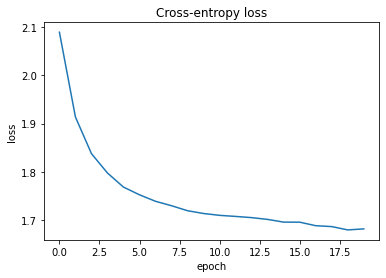

----------------------------------------------------                            
Hyperparameter combinations:                                                    
{'activation_function': 'tanh', 'dropout_prob': 0.27122327296213233, 'layer_nodes_combinations': (48, 24, 5), 'optimizer': 'Adam', 'regularizer': 0.003}
Emotional classification accuracy for training : 0.368                          
Emotional classification accuracy for validation  : 0.368                       
Running time for training : 96.62 s                                             
Number of parameters : 111983                                                   
 20%|█▊       | 1/5 [03:18<06:34, 98.70s/trial, best loss: -0.38673725724220276]

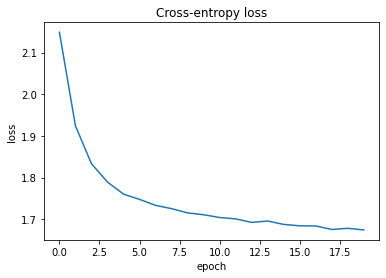

----------------------------------------------------                            
Hyperparameter combinations:                                                    
{'activation_function': 'relu', 'dropout_prob': 0.24367277130489629, 'layer_nodes_combinations': (32, 16, 10), 'optimizer': 'sgd', 'regularizer': 0.003}
Emotional classification accuracy for training : 0.291                          
Emotional classification accuracy for validation  : 0.305                       
Running time for training : 103.30 s                                            
Number of parameters : 74535                                                    
 40%|███▌     | 2/5 [05:03<04:58, 99.53s/trial, best loss: -0.38673725724220276]

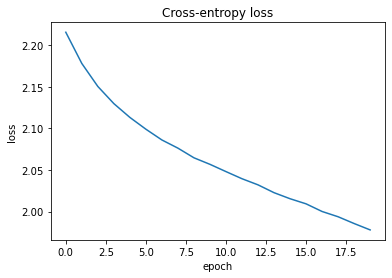

----------------------------------------------------                            
Hyperparameter combinations:                                                    
{'activation_function': 'relu', 'dropout_prob': 0.42330427173242413, 'layer_nodes_combinations': (32, 16, 10), 'optimizer': 'sgd', 'regularizer': 0.05}
Emotional classification accuracy for training : 0.251                          
Emotional classification accuracy for validation  : 0.249                       
Running time for training : 74.19 s                                             
Number of parameters : 74535                                                    
 60%|████▊   | 3/5 [06:19<03:24, 102.23s/trial, best loss: -0.38673725724220276]

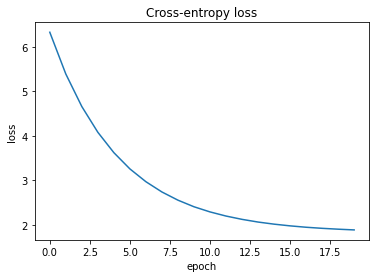

----------------------------------------------------                            
Hyperparameter combinations:                                                    
{'activation_function': 'tanh', 'dropout_prob': 0.29660814637999505, 'layer_nodes_combinations': (48, 24, 5), 'optimizer': 'Adam', 'regularizer': 0.05}
Emotional classification accuracy for training : 0.255                          
Emotional classification accuracy for validation  : 0.250                       
Running time for training : 91.72 s                                             
Number of parameters : 111983                                                   
 80%|███████▏ | 4/5 [07:53<01:31, 91.83s/trial, best loss: -0.38673725724220276]

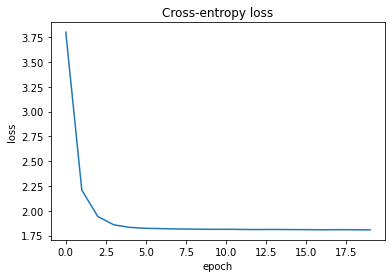

----------------------------------------------------                            
100%|█████████| 5/5 [07:53<00:00, 94.78s/trial, best loss: -0.38673725724220276]


In [38]:
# Search Space
space_fnn = {
    'layer_nodes_combinations': hp.choice('layer_nodes_combinations', [[32,16,10],[48,24,5]]),
    # Strides for Convolutions
    'activation_function': hp.choice('activation_function', ['tanh', 'relu']),
    # Dropout probabilities
    'dropout_prob': hp.uniform('dropout_prob', 0.1, 0.45),
    # regularization
    'regularizer': hp.choice('regularizer', [0.003,0.02,0.05]),
    # optimizer choice
    'optimizer': hp.choice('optimizer', ['Adam','sgd']),
}

trials_fnn = Trials()

# Find the best hyperparameters
best_fnn = fmin(
        hyperparameter_fnn,
        space_fnn,
        algo=tpe.suggest,
        trials=trials_fnn,
        max_evals=5,
    )

Hyperparameter combinations:  {'activation_function': 'tanh', 'dropout_prob': 0.44848088453732804, 'layer_nodes_combinations': (32, 16, 10), 'optimizer': 'Adam', 'regularizer': 0.003}

Emotional classification accuracy for training : 0.372
Emotional classification accuracy for validation  : 0.366
Running time for training : 66.71 s
Number of parameters : 74535


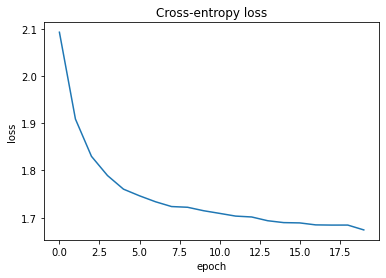

----------------------------------------------------
Accuracy of Test:  0.3638896644115448


In [42]:
best_hyper_fnn = space_eval(space_fnn,best_fnn)
fnn_tune = hyperparameter_fnn(best_hyper_fnn)

performance_fnn = fnn_tune['model'].evaluate(x_test_fnn, y_test,verbose=0)

print("==================================")
print("Accuracy of Test: ", performance_fnn[1])

In [10]:
x_train_cnn = train_images_normalize.values.reshape((-1,48,48,1))
x_val_cnn = val_images_normalize.values.reshape((-1,48,48,1))
x_test_cnn = test_images_normalize.values.reshape((-1,48,48,1))

In [11]:
def hyperparameter_cnn(hyperparameter):
    K.clear_session()  
    cnn_model = Sequential()

    for layers in hyperparameter['convolution']:
        for layerSize in layers:
            cnn_model.add(Conv2D(layerSize, kernel_size=hyperparameter['convKernelSize'],padding='same', strides=hyperparameter['stride_size'], activation=hyperparameter['activation_function']))
        cnn_model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
        cnn_model.add(Dropout(hyperparameter['dropout_prob']))

    cnn_model.add(Flatten())
    cnn_model.add(Dense(hyperparameter['DenseNeurons'], activation=hyperparameter['activation_function']))

    cnn_model.add(Dense(5, activation='softmax'))

    cnn_model.compile(optimizer=hyperparameter['optimizer'], loss='categorical_crossentropy', metrics=['accuracy'],)

    start = time.time()
    cnn_history = cnn_model.fit(x_train_cnn, y_train, epochs=20, batch_size=256, verbose=0)
    end = time.time()


    performance = cnn_model.evaluate(x_val_cnn, y_val, verbose=0)

    print("----------------------------------------------------")

    print("Hyperparameters: ", (hyperparameter))
  
    print("Accuracy on Training : %.3f" % (cnn_history.history['accuracy'][-1]))
    print("Accuracy on Validation : %.3f" % (performance[1]))
    print("Training time : %.2f s" % (end-start))
    print("No. of parameters : %d" % (cnn_model.count_params()))
    print("----------------------------------------------------")
    
 
    plt.plot(cnn_history.history['loss'])
    plt.title('Cross-entropy loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()
    print("----------------------------------------------------")

# We want to minimize loss i.e. negative of accuracy
    return({"status": STATUS_OK, "loss": -1*performance[1], "model":cnn_model})

In [ ]:
# Define search space for hyper-parameters
space_cnn = {
    # activation function
    'activation_function': hp.choice('activation_function', ['tanh', 'relu']),
    # drop-out probability
    'dropout_prob': hp.uniform('dropout_prob', 0.1, 0.35),
    # optimizer 
    'optimizer': hp.choice('optimizer', ['Adam','sgd']),
    # Convolution
    'convolution': hp.choice('convolution', [[[25,32],[50,50]],[[30],[50],[120]]]),
    # Dense layer
    'DenseNeurons': hp.choice('DenseNeurons', [100,200]),
    # kernel
    'convKernelSize': hp.choice('convKernelSize', [1, 2, 4]),
    # stride
    'stride_size': hp.choice('stride_size', [1, 2]), 
}

trials_cnn = Trials()

# Find the best hyperparameters
best_cnn = fmin(
        hyperparameter_cnn,
        space_cnn,
        algo=tpe.suggest,
        trials=trials_cnn,
        max_evals=5,
    )

In [14]:
def optimize_cnn(hyperparameter):
    K.clear_session()  
    cnn_model = Sequential()

    for layer_sequence in hyperparameter['conv2d_config']:
        for layer_size in layer_sequence:
            cnn_model.add(Conv2D(layer_size, kernel_size=hyperparameter['conv_kernel_size'],padding='same', strides=hyperparameter['stride_size'], activation=hyperparameter['activation_function']))
    cnn_model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    cnn_model.add(Dropout(hyperparameter['dropout_prob']))

    cnn_model.add(Flatten())
    cnn_model.add(Dense(hyperparameter['dense_layer_neurons'], activation=hyperparameter['activation_function']))

    cnn_model.add(Dense(7, activation='softmax'))

    cnn_model.compile(optimizer=hyperparameter['optimizer'], loss='categorical_crossentropy', metrics=['accuracy'],)

    start = time.time()
    cnn_history = cnn_model.fit(x_train_cnn, y_train, epochs=10, batch_size=120, verbose=0)
    end = time.time()

#   print(cnn_model.summary())

    performance = cnn_model.evaluate(x_val_cnn, y_val, verbose=0)

    print("----------------------------------------------------")

    print("Hyperparameters: ", (hyperparameter))
    print()
    print("No. of parameters : %d" % (cnn_model.count_params()))
    print("Training time : %.2f s" % (end-start))
    print("Training Accuracy : %.3f" % (cnn_history.history['accuracy'][-1]))
    print("Validation Accuracy : %.3f" % (performance[1]))
    print("----------------------------------------------------")
    
    #if random.random() < 0.35:
    plt.plot(cnn_history.history['loss'])
    plt.title('Cross-entropy loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()
    print("----------------------------------------------------")

# We want to minimize loss i.e. negative of accuracy
    return({"status": STATUS_OK, "loss": -1*performance[1], "model":cnn_model})

  0%|                                     | 0/3 [00:00<?, ?trial/s, best loss=?]

2021-11-21 23:09:51.870515: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-21 23:09:51.874920: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 4. Tune using inter_op_parallelism_threads for best performance.


----------------------------------------------------                            
Hyperparameters:                                                                
{'activation_function': 'relu', 'conv2d_config': ((30, 30), (60, 60)), 'conv_kernel_size': 7, 'dense_layer_neurons': 240, 'dropout_prob': 0.40194682205211657, 'optimizer': 'sgd', 'stride_size': 4}
No. of parameters : 326677                                                      
Training time : 299.53 s                                                        
Training Accuracy : 0.251                                                       
Validation Accuracy : 0.249                                                     
----------------------------------------------------                            
  0%|                                     | 0/3 [05:02<?, ?trial/s, best loss=?]

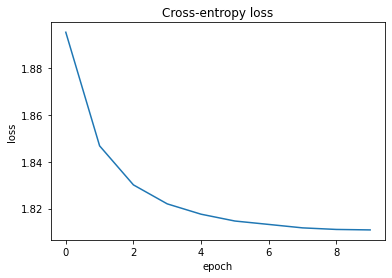

----------------------------------------------------                            
----------------------------------------------------                            
Hyperparameters:                                                                
{'activation_function': 'relu', 'conv2d_config': ((30, 30), (60, 60)), 'conv_kernel_size': 3, 'dense_layer_neurons': 240, 'dropout_prob': 0.43511092317705347, 'optimizer': 'Adam', 'stride_size': 2}
No. of parameters : 116677                                                      
Training time : 542.75 s                                                        
Training Accuracy : 0.502                                                       
Validation Accuracy : 0.480                                                     
----------------------------------------------------                            
 33%|██▋     | 1/3 [14:08<10:05, 302.64s/trial, best loss: -0.24937307834625244]

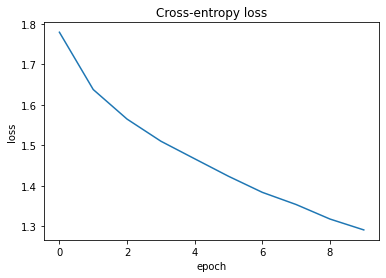

----------------------------------------------------                            
----------------------------------------------------                            
Hyperparameters:                                                                
{'activation_function': 'tanh', 'conv2d_config': ((30,), (60,), (120,)), 'conv_kernel_size': 3, 'dense_layer_neurons': 120, 'dropout_prob': 0.40288978114128227, 'optimizer': 'Adam', 'stride_size': 2}
No. of parameters : 212047                                                      
Training time : 848.60 s                                                        
Training Accuracy : 0.480                                                       
Validation Accuracy : 0.460                                                     
----------------------------------------------------                            
 67%|█████▎  | 2/3 [28:26<07:25, 445.99s/trial, best loss: -0.47979938983917236]

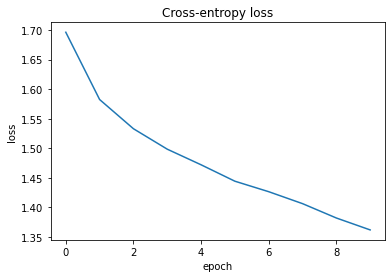

----------------------------------------------------                            
100%|████████| 3/3 [28:26<00:00, 568.77s/trial, best loss: -0.47979938983917236]


In [15]:
# Define search space for hyper-parameters
space_cnn = {
    # The convolution layers and sizes
    'conv2d_config': hp.choice('conv2d_config', [[[30,30],[60,60]],[[30],[60],[120]]]),
    # The last dense layer size
    'dense_layer_neurons': hp.choice('dense_layer_neurons', [120,240]),
    # The kernel_size for convolutions:
    'conv_kernel_size': hp.choice('conv_kernel_size', [1, 3, 7]),
    # The stride_size for convolutions:
    'stride_size': hp.choice('stride_size', [2, 4]),
    # The activation function
    'activation_function': hp.choice('activation_function', ['tanh', 'relu']),
    # Uniform distribution in finding appropriate dropout values
    'dropout_prob': hp.uniform('dropout_prob', 0.4, 0.5),
    # Choice of optimizer 
    'optimizer': hp.choice('optimizer', ['Adam','sgd']),
}

trials_cnn = Trials()

# Find the best hyperparameters
best_cnn = fmin(
        optimize_cnn,
        space_cnn,
        algo=tpe.suggest,
        trials=trials_cnn,
        max_evals=3,
    )

Best Hyperparameters {'activation_function': 1, 'conv2d_config': 0, 'conv_kernel_size': 1, 'dense_layer_neurons': 1, 'dropout_prob': 0.43511092317705347, 'optimizer': 0, 'stride_size': 0}
----------------------------------------------------
Hyperparameters:  {'activation_function': 'relu', 'conv2d_config': ((30, 30), (60, 60)), 'conv_kernel_size': 3, 'dense_layer_neurons': 240, 'dropout_prob': 0.43511092317705347, 'optimizer': 'Adam', 'stride_size': 2}

No. of parameters : 116677
Training time : 537.34 s
Training Accuracy : 0.515
Validation Accuracy : 0.484
----------------------------------------------------


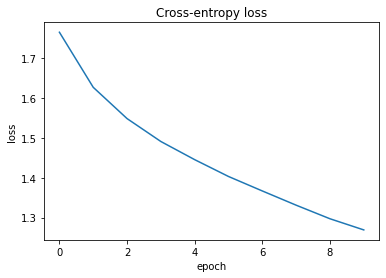

----------------------------------------------------
Test Accuracy:  0.4789634943008423


In [17]:
print("==================================")
print("Best Hyperparameters", best_cnn)

best_hyper_cnn = space_eval(space_cnn,best_cnn)
cnn_tuned = optimize_cnn(best_hyper_cnn)

performance_cnn = cnn_tuned['model'].evaluate(x_test_cnn, y_test,verbose=0)

print("==================================")
print("Test Accuracy: ", performance_cnn[1])